In [ ]:
import os
import xarray as xr 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats
import sys
sys.path.append(r'C:\checkouts\python\phd\modules')
from plotfuncs import density_scatter
sys.path.append(r'C:\checkouts\python\phd\paper2_profile')
from local_functions import *
from matplotlib.dates import DateFormatter
import xrMethodAccessors
%reload_ext autoreload
%autoreload 2

plotFilePath = r'c:\Users\marliesvanderl\phd\analysis\fig\paper2_profile\draft2'
if not os.path.exists(plotFilePath):
    os.mkdir(plotFilePath)


In [4]:
# load hydro data 
ds = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\vec008\tailored15min_uc2_v2\vec008.nc')
ds['uc'] = ds.uc.where(ds.uc.min(dim='N')>-2)

dsd = ds.dropna(dim='t', how='any', subset=['u_ss', 'v_ss', 'Tp', 'Ur'])
uss = dsd.u_ss
vss = dsd.v_ss
umag = np.sqrt(uss**2+vss**2)
uorbmax = umag.quantile(0.90, dim='N')

uss = ds.u_ss
vss = ds.v_ss
umag = np.sqrt(uss**2+vss**2)
uorbmax = umag.quantile(0.90, dim='N')

ds['uorbmag'] = umag
ds['uorbmax'] = uorbmax

ds['uorb'] = umag.mean(dim='N')  # np.sqrt(2)*
ds['umean'] = np.sqrt(ds.u.mean(dim='N')**2+ds.v.mean(dim='N')**2)
# khelifa oullet: why divided by pi?
# ds['uwc'] = ((ds['uorb']/np.pi)**2+ds['umean']**2+2*ds['uorb']/np.pi*ds['umean']*np.abs(np.cos((ds.uang-ds.puvdir)/180*np.pi))**(0.5)
# my version without pi
ds['uwc'] = np.sqrt((ds['umean']+np.abs(np.cos((ds.uang-ds.puvdir)/180*np.pi))*ds['uorbmax'])**2+(ds['uorbmax']*np.abs(np.sin((ds.uang-ds.puvdir)/180*np.pi)))**2)
# Van Rijn 2007:
# ds['uwc'] = np.sqrt(ds.uorb**2+ds.umean**2)
# Ribberink 2008:
ds['uwc2'] = 2*np.sqrt((ds.u**2+ds.v**2).mean(dim='N'))
# my version more based on maximum velocities
ds['uwc2'] = np.sqrt(ds.u**2+ds.v**2).quantile(0.90, dim='N')

ds['a'] = np.sqrt(2)*ds.ud_ssm/(2*np.pi/ds.Tp) # significant orbital exursion

ds['u_ssm_c'] = np.cos((ds.puvdir-122)/180*np.pi)*ds.u_ssm
ds['u_ssm_l'] = np.sin((ds.puvdir-122)/180*np.pi)*ds.u_ssm

ds = ds.drop_dims(['f','theta'])

d50 = 630e-6
ds['psi_umean'] = psi(ds['umean'], d50, delta=1.65, g=9.8)
ds['psi_uorb'] = psi(ds['uorb'], d50, delta=1.65, g=9.8)
ds['psi_uorbmax'] = psi(ds['uorbmax'], d50, delta=1.65, g=9.8)
# ds['psi_uwc'] = psi(ds['uwc'], d50, delta=1.65, g=9.8)
ds['psi_uwc'] = psi(ds['uwc2'], d50, delta=1.65, g=9.8)

ds['u_ucm'] = ds['uc']-ds['ucm']
ds['u_ss2'] = ds.puv.band_pass_filter_ss('u_ucm',fpminfac=0.5, fpmaxfac=100)
ds['u_ig2'] = ds['u_ucm']-ds['u_ss2']


c:\Users\marliesvanderl\AppData\Local\miniforge3\envs\work\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
c:\Users\marliesvanderl\AppData\Local\miniforge3\envs\work\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


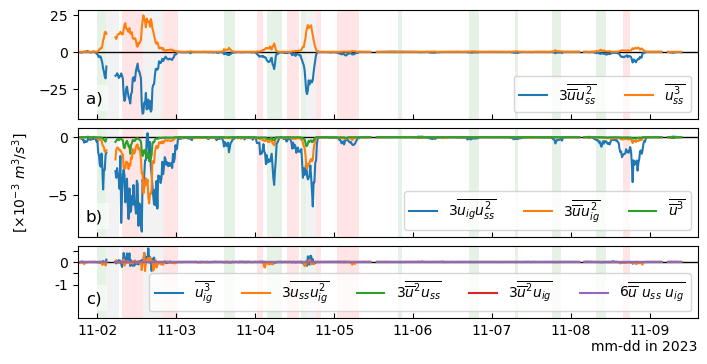

In [5]:
def log_mod(qs):
    return 1e3*qs # np.sign(qs)*np.log(np.abs(qs/1e-4)+1) # 1e4*qs #

fig, ax = plt.subplots(3, 1, sharex=True, figsize=[8, 4], gridspec_kw={'height_ratios': [3, 3, 2]})

ax[0].plot(ds.t, (log_mod(3*ds.ucm*ds.u_ss2**2).mean(dim='N')), label=r'$3 \overline{\overline{u} u_{ss}^2}$')
ax[0].plot(ds.t, (log_mod((ds.u_ss2**3).mean(dim='N'))), label=r'$\overline{u_{ss}^3}$') 
ax[1].plot(ds.t, (log_mod(3*ds.u_ss2**2*ds.u_ig2).mean(dim='N')), label=r'$3 \overline{u_{ig}u_{ss}^2} $')
ax[1].plot(ds.t, (log_mod(3*ds.ucm*ds.u_ig2**2).mean(dim='N')), label=r'$3 \overline{\overline{u}u_{ig}^2}$')
ax[1].plot(ds.t, (log_mod(ds.ucm**3)), label=r'$\overline{\overline{u}^3}$')
ax[2].plot(ds.t, (log_mod((ds.u_ig2**3).mean(dim='N'))), label=r'$\overline{u_{ig}^3}$') 
ax[2].plot(ds.t, (log_mod(3*ds.u_ss2*ds.u_ig2**2).mean(dim='N')), label=r'$3 \overline{u_{ss}u_{ig}^2}$') 
ax[2].plot(ds.t, (log_mod(3*ds.ucm**2*(ds.u_ss2).mean(dim='N'))), label=r'$3 \overline{\overline{u}^2u_{ss}}$')
ax[2].plot(ds.t, (log_mod(3*ds.ucm**2*(ds.u_ig2).mean(dim='N'))), label=r'$3 \overline{\overline{u}^2u_{ig}}$')
ax[2].plot(ds.t, (log_mod(6*ds.ucm*(ds.u_ss2*ds.u_ig2).mean(dim='N'))), label=r'$6 \overline{\overline{u}\ u_{ss}\ u_{ig}}$')

ax[2].set_ylim([-2.5, 0.7])
ax[2].set_yticks([-1, -0.5, 0, 0.5])
ax[2].set_yticklabels(['-1', '', '0', ''])
for axi in ax:
    axi.set_title('')
    axi.set_xlabel('')
    # axi.grid(linestyle=':', color='grey', linewidth=0.5)
    axi.axhline(0, color='k', linewidth=1, zorder=-2)
    axi.tick_params(axis="x", direction="in")
    axi.legend(loc='lower right', ncols=5)

ax[1].set_ylabel(r'[$\times 10^{-3}\ m^3/s^3$]')

for axi in ax:
    axi.yaxis.set_label_coords(-0.077, 0.5)
fig.subplots_adjust(hspace=0.1)

ax[-1].xaxis.set_major_formatter(DateFormatter('%m-%d'))
ax[-1].text(1, -0.3, 'mm-dd in 2023',transform = ax[-1].transAxes, ha='right', va='top')

ax[-1].set_xlim([ds.t.min(), ds.t.max()])
import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, 20 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)', 'c)', 'd)', 'e)', 'f)'], ax):
    t = axi.text(0, 0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

# plot_migrating_moments2(ax)
plot_migrating_moments(ax, alpha=0.1)
plt.savefig(os.path.join(plotFilePath, 'velocity_moments_decomposition2_vspan.png'), dpi=200, bbox_inches='tight')


In [6]:
# 1D ripple geometry and migration
rib1d = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\processed\movmean_footprint2_stats1D_jawindow0_lf4_excludesmallk_ls5.nc')

# add min and max angles of minimum labda
rib1d = rib1d.rename({'thetmin':'phi'})
sel = rib1d.where(rib1d.theta>-45)
rib1d['thetmin'] = sel['theta'].expand_dims(dim={"time": len(sel.time)}).where(sel.labda==rib1d.labdamin).min(dim='theta')
rib1d['thetmax'] = sel['theta'].expand_dims(dim={"time": len(sel.time)}).where(sel.labda==rib1d.labdamin).max(dim='theta')

#remove outliers (if any)
rib1d = rib1d.where(rib1d.etamin<0.25)

ripple_dir = (rib1d.phi).rolling(time=8, min_periods=6, center=True).median()
ripple_dir_offshore = xr.where(ripple_dir<0, ripple_dir+180, ripple_dir-180)

# 1D Migration rates estimate
mig1d = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\processed\stats1D_migrationrates_250114_refined5_avdir.nc')
mig1d = mig1d.resample(time='15T').nearest(tolerance='10T')

# add direction to migration in 1d
mig1d['phi'] = ripple_dir.interp_like(mig1d.time)
mig1d['deltat'] = ((mig1d.time-mig1d.tprev)/np.timedelta64(1, 's'))

mig1d['dmig_cross'] = np.cos((mig1d.phi)/180*np.pi)*mig1d.dmig
mig1d['vmig_cross'] = mig1d.dmig_cross*3600/(mig1d.deltat)

In [7]:
# 2D ripple geometry and migration

rib2d = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\processed\movmean_footprint2_stats2D_jawindow0_lf1_excludesmallk_width.nc')
spread = xr.open_dataarray(r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\processed\directional_spreading.nc')

mig = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\processed\movmean_footprint2_stats2D_jawindow1_migrationrates.nc')

#make sure that we only include positive time increments
mig['deltat'] = ((mig.time-mig.tprev)/np.timedelta64(1, 's'))
mig = mig.where(mig.deltat>0).dropna(dim='time')
mig = mig.resample(time='15T').nearest(tolerance='10T')

# fix the migration direction
mig['phi'] = ('time', np.where((mig['phi']+180)<=180, mig['phi']+180, mig['phi']-180))

# decompose in cross- and alongshore
mig['dmig_cross'] = np.cos((mig.phi)/180*np.pi)*mig.dmig
mig['dmig_along'] = np.sin((mig.phi)/180*np.pi)*mig.dmig
mig['vmig_cross'] = mig.dmig_cross*3600/(mig.deltat)
mig['vmig_along'] = mig.dmig_along*3600/(mig.deltat)

mig['puvdir']   = ds.rename({'t':'time'}).puvdir.interp_like(mig.time)
mig['ulm']      = ds.rename({'t':'time'}).ulm.interp_like(mig.time)
mig['ucm']      = ds.rename({'t':'time'}).ucm.interp_like(mig.time)
mig['uorb']     = ds.rename({'t':'time'}).uorbmax.interp_like(mig.time)
mig['psi_uorb'] = ds.rename({'t':'time'}).psi_uorbmax.interp_like(mig.time)
mig['labda3d']  = rib2d.labda.interp_like(mig.time)

# remove unreliable period within the storm
mig = mig.where(np.logical_or(mig.time<pd.to_datetime('20231102 14:15'), mig.time>pd.to_datetime('20231102 19:45')))

# remove migration information when no labda could be reconstructed in 3D
mig = mig.where(~np.isnan(mig.labda3d))

# remove unreliable estimates of more than 35 cm/hr
mig = mig.where(mig.vmig_cross<35)
mig = mig.where(mig.vmig_along<35)

rib2d['vmig_cross'] = mig['vmig_cross']
rib2d['vmig_along'] = mig['vmig_along']
rib2d['p_mig'] = mig['p']
rib2d['spreading'] = spread

voeg de geometrie toe aan de hydro dataset

In [8]:
pmin = 0.5
pmin1d = 0.7

ds['eta'] = rib1d.etamin.rename({'time':'t'}).interp_like(ds.t)
ds['labda'] = rib1d.labdamin.rename({'time':'t'}).interp_like(ds.t)
ds['phi'] = ripple_dir.rename({'time':'t'}).interp_like(ds.t)
ds['labda3d'] = rib2d.labda.rename({'time':'t'}).interp_like(ds.t)

ds['vmig_cross'] = mig.vmig_cross.where(np.minimum(mig.percvalid1, mig.percvalid2)>0.5).where(mig.p>pmin).rename({'time':'t'}).interp_like(ds.t)
ds['vmig_cross1d'] = mig1d.vmig_cross.where(mig.p>pmin1d).rename({'time':'t'}).interp_like(ds.t)
ds['vmig_along'] = mig.vmig_along.where(np.minimum(mig.percvalid1, mig.percvalid2)>0.5).where(mig.p>pmin).rename({'time':'t'}).interp_like(ds.t)

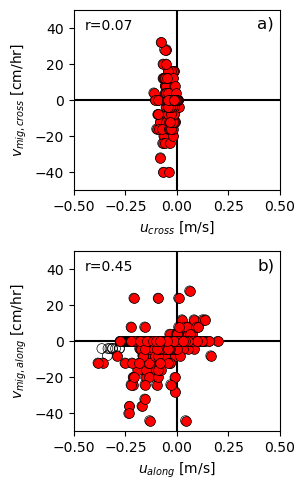

In [9]:
thr = 1

migsel = mig.where(mig.p>pmin).where(mig.psi_uorb>thr)
migplot = mig.where(mig.p>pmin)

fig, ax = plt.subplots(2, 1, figsize=[3, 5])
ax[0].scatter(mig.ucm, migplot.vmig_cross,c='None', edgecolor='k', linewidth=0.5, s=50)
ax[0].scatter(mig.ucm, migsel.vmig_cross,c='r', edgecolor='k', linewidth=0.5, s=50)
ax[0].set_xlim([-0.5, 0.5])
ax[0].set_ylim([-50, 50])
ax[0].axhline(0, c='k', zorder=-2)
ax[0].axvline(0, c='k', zorder=-2)
ax[0].set_ylabel('$v_{mig, cross}$ [cm/hr]')
ax[0].set_xlabel('$u_{cross}$ [m/s]')

q = migsel.vmig_along
qs = mig.ucm
ax[0].text(0.05, 0.95, 'r={:.2f}'.format(spearman_stats(qs, q).correlation), transform=ax[0].transAxes, ha='left', va='top', fontsize=10)

ax[1].scatter(mig.ulm, migplot.vmig_along,c='None', edgecolor='k', linewidth=0.5, s=50)
ax[1].scatter(migsel.ulm, migsel.vmig_along,c='r', edgecolor='k', linewidth=0.5, s=50)
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([-50, 50])
ax[1].axhline(0, c='k', zorder=-2)
ax[1].axvline(0, c='k', zorder=-2)
ax[1].set_ylabel('$v_{mig, along}$ [cm/hr]')
ax[1].set_xlabel('$u_{along}$ [m/s]')

q = migsel.vmig_along
qs = migsel.ulm
ax[1].text(0.05, 0.95, 'r={:.2f}'.format(spearman_stats(qs, q).correlation), transform=ax[1].transAxes, ha='left', va='top', fontsize=10)

fig.tight_layout()

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)'], ax):
    t = axi.text(0.85, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

plt.savefig(os.path.join(plotFilePath, 'meanflow_migration.png'), dpi=200, bbox_inches='tight')

c:\Users\marliesvanderl\AppData\Local\miniforge3\envs\work\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


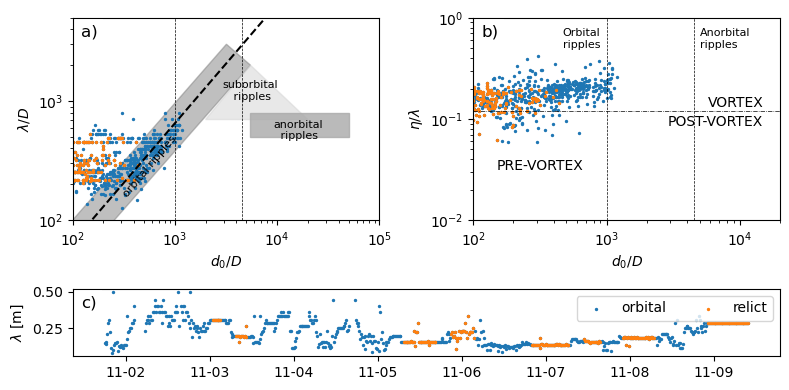

In [10]:
relict_times0 = [
    ds.t.sel(t=slice('20231103 01:00', '20231103 03:00')).values,
    ds.t.sel(t=slice('20231103 07:30','20231103 10:30')).values,
    # ds.t.sel(t=slice('20231103 21:30', '20231103 23:30')).values,
    ds.t.sel(t=slice('20231105 07:30', '20231105 16:30')).values,
    ds.t.sel(t=slice('20231105 21:00', '20231106 03:30')).values,
    # ds.t.sel(t=slice('20231106 10:00','20231106 15:30')).values,
    ds.t.sel(t=slice('20231106 20:00', '20231107 06:30')).values,
    ds.t.sel(t=slice('20231107 11:00', '20231107 15:30')).values,
    ds.t.sel(t=slice('20231107 22:00', '20231108 07:00')).values,
    ds.t.sel(t=slice('20231108 22:30', '20231109 12:00')).values,
]

relict_times = [x for xs in relict_times0 for x in xs]

# clifton diagram
from matplotlib.patches import Polygon 

# ripple cutof
umag = np.sqrt(ds.u_ss**2+ds.v_ss**2)
uorbmax = umag.quantile(0.95, dim='N')
ds['uorbmax'] = uorbmax
d0 = ds['Tmm10']*ds['uorbmax']/np.pi  # according to clifton and dingler the orbital excursion with here uorbmax is 90%

fig, ax = plt.subplots(2, 2, figsize=[8,4], gridspec_kw={'height_ratios': [3, 1]})
ax = [ax[0,0], ax[0, 1], ax[1,:]]

gs = ax[2][0].get_gridspec()
# remove the underlying Axes
ax[2][0].remove()
ax[2][1].remove()
axbig = fig.add_subplot(gs[-1, 0:])

ax[0].scatter(d0/630e-6, ds['labda']/630e-6, label='all data', s=2)
ax[0].scatter(d0.sel(t=relict_times)/630e-6, ds.sel(t=relict_times)['labda']/630e-6, label='relic', s=2) 


# Miller and Komar 1980 a, as mentioned in Clifton and Dinler 1984 equation 8
ax[0].plot(np.linspace(0, 5, 100)/600e-6, 0.65*np.linspace(0, 5, 100)/600e-6, label='Miller and Komar (1980)', linestyle='--', color='k')  
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim([1e2, 1e5])
ax[0].set_ylim([1e2, 5e3])
ax[0].set_xlabel('$d_0/D$')
ax[0].set_ylabel('$\lambda/D$')
ax[0].axvline(1e3, linestyle='--', color='k', linewidth=0.5)
ax[0].axvline(4.5e3, linestyle='--', color='k', linewidth=0.5)
r = Polygon([(1e2, 4e1), (5.5e3, 2e3), (3.2e3, 3.0e3), (1e2, 1e2)], color='grey', alpha=0.5, zorder=-2)
ax[0].add_patch(r)
r = Polygon([(5.5e3, 2e3), (2e3, 7e2), (2e4, 7e2)], color='lightgrey', alpha=0.5, zorder=-2)
ax[0].add_patch(r)
r = Polygon([(5.5e3, 5e2), (5e4, 5e2), (5e4, 8e2), (5.5e3, 8e2)], color='darkgrey', alpha=0.8, zorder=-2)
ax[0].add_patch(r)
# ax[0].legend()
ax[0].text(3e2, 1.5e2, 'orbital ripples', ha='left', va='bottom', rotation=50, fontsize=8)
ax[0].text(5.5e3, 1.5e3,'suborbital\n ripples', ha='center', va='top', fontsize=8)
ax[0].text(1.6e4, 7e2,'anorbital\n ripples', ha='center', va='top', fontsize=8)

ax[1].scatter(d0/630e-6, ds['eta']/ds['labda'], s=2, zorder=-2) 
ax[1].scatter(d0.sel(t=relict_times)/630e-6, (ds['eta']/ds['labda']).sel(t=relict_times), s=2) # relict
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([1e2, 2e4])
ax[1].set_ylim([1e-2, 1e0])
ax[1].set_xlabel('$d_0/D$')
ax[1].set_ylabel('$\eta/\lambda$')
ax[1].axhline(1.2e-1, linestyle='-.', color='k', linewidth=0.5)
ax[1].axvline(1e3, linestyle='--', color='k', linewidth=0.5)
ax[1].axvline(4.5e3, linestyle='--', color='k', linewidth=0.5)
ax[1].text(0.9e3, 8e-1, 'Orbital', ha='right', va='top', fontsize=8)
ax[1].text(0.9e3, 6e-1, 'ripples', ha='right', va='top', fontsize=8)
ax[1].text(1.5e4, 1.7e-1, 'VORTEX', ha='right', va='top', fontsize=10)
ax[1].text(5.0e3, 8e-1, 'Anorbital', ha='left', va='top', fontsize=8)
ax[1].text(5.0e3, 6e-1, 'ripples', ha='left', va='top', fontsize=8)
ax[1].text(1.5e2, 4e-2, 'PRE-VORTEX', ha='left', va='top', fontsize=10)
ax[1].text(1.5e4, 1.1e-1, 'POST-VORTEX', ha='right', va='top', fontsize=10)

axbig.scatter(ds.t, ds.labda, s=2, label='orbital')
axbig.scatter(ds.sel(t=relict_times).t, ds.sel(t=relict_times).labda, s=2, label='relict')
axbig.legend(ncols=2)
axbig.set_ylabel('$\lambda$ [m]')
axbig.xaxis.set_major_formatter(DateFormatter('%m-%d'))

fig.tight_layout()

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)', 'c)'], [ax[0], ax[1], axbig]):
    t = axi.text(0.0, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

plt.savefig(plotFilePath, dpi=200, bbox_inches='tight')

In [11]:
rel = ds[['labda','eta']].sel(t=relict_times).dropna(dim='t')
all = ds[['labda','eta']].dropna(dim='t')
orb = ds[['labda','eta']].sel(t=np.setdiff1d(ds.t.values, relict_times)).dropna(dim='t')
print('orbital = {:.0f}%'.format(100*len(orb.labda.values)/len(all.labda.values)))
print('relict = {:.0f}%'.format(100*len(rel.labda.values)/len(all.labda.values)))
print('orbital vortex = {:.0f}%'.format(100*((orb.eta/orb.labda)>0.12).sum().values/len(orb.labda.values)))
print('relict vortex = {:.0f}%'.format(100*((rel.eta/rel.labda)>0.12).sum().values/len(rel.labda.values)))

orbital = 68%
relict = 32%
orbital vortex = 91%
relict vortex = 86%


Visualiseer wat van de hydro

Text(0.5, 1.0, '')

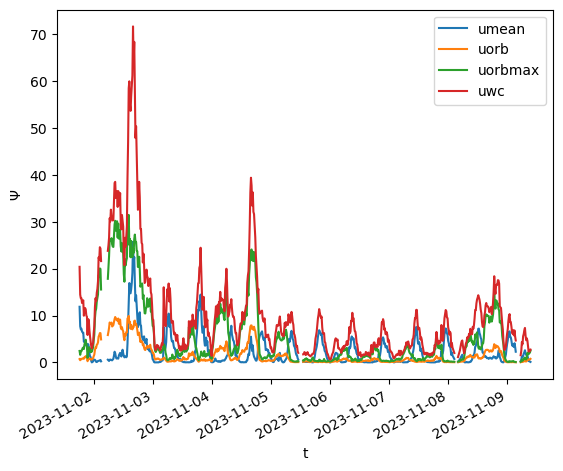

In [12]:
plt.figure()
ds.psi_umean.plot(label='umean')
ds.psi_uorb.plot(label='uorb')
ds.psi_uorbmax.plot(label='uorbmax')
ds.psi_uwc.plot(label='uwc')
# ds.psi_uwc2.plot(label='uwc2')
plt.legend()
plt.ylabel(r'$\Psi$')
plt.title('')

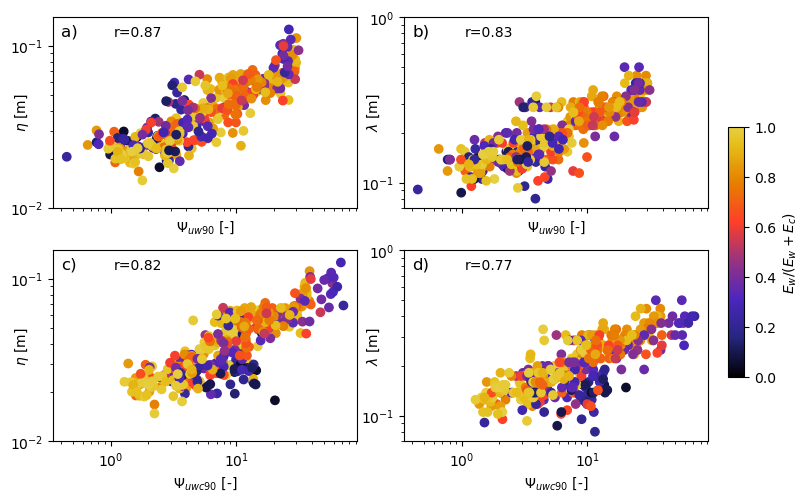

In [13]:
# plot both ripple height and length as function of mobility number

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('CMRmap')
new_cmap = truncate_colormap(cmap, 0, 0.8)

# ripple cutof
aa=2e-2
bb=1.2
# aa=2.4e-2
# bb=1.5
# aa=1.8e-2
# bb=1.8
dsi = ds[['uorb','umean', 'psi_uwc',  'psi_uorbmax', 'labda','eta']].where(ds.labda<=(aa+bb*d0))
# dsi = ds.sel(t=np.setdiff1d(ds.t.values, relict_times))
# dsi = ds

fig, ax = plt.subplots(2, 2, figsize=[8, 5], sharex=True)
a = dsi.psi_uorbmax.values 
b = dsi.eta.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
ax[0, 0].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **{'vmin':0, 'vmax':1, 'cmap':new_cmap})
ax[0, 0].set_xlabel(r'$\Psi_{uw90}$ [-]')
ax[0, 0].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[0, 0].transAxes)
ax[0, 0].text(-0.1, 0.5, '$\eta$ [m]', transform = ax[0, 0].transAxes, rotation=90, ha='center', va='center')


a = dsi.psi_uwc.values
b = dsi.eta.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
ax[1, 0].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **{'vmin':0, 'vmax':1, 'cmap':new_cmap})
ax[1, 0].set_xlabel(r'$\Psi_{uwc90}$ [-]')
ax[1, 0].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[1, 0].transAxes)
ax[1, 0].text(-0.1, 0.5, '$\eta$ [m]', transform = ax[1, 0].transAxes, rotation=90, ha='center', va='center')


a = dsi.psi_uorbmax.values
b = dsi.labda.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
ax[0, 1].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **{'vmin':0, 'vmax':1, 'cmap':new_cmap})
ax[0, 1].set_xlabel(r'$\Psi_{uw90}$ [-]')
ax[0, 1].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[0, 1].transAxes)
ax[0, 1].text(-0.1, 0.5, '$\lambda$ [m]', transform = ax[0, 1].transAxes, rotation=90, ha='center', va='center')

a = dsi.psi_uwc.values
b = dsi.labda.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
im = ax[1, 1].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **{'vmin':0, 'vmax':1, 'cmap':new_cmap})
ax[1, 1].set_xlabel(r'$\Psi_{uwc90}$ [-]')
ax[1, 1].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[1, 1].transAxes)
ax[1, 1].text(-0.1, 0.5, '$\lambda$ [m]', transform = ax[1, 1].transAxes, rotation=90, ha='center', va='center')

fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.25, 0.02, 0.5])
plt.colorbar(im, label='$E_w$/($E_w+E_c$)', cax=cbar_ax)

for axi in ax.reshape(-1):
    axi.set_xscale('log')
    axi.set_yscale('log')

ax[0, 0].set_ylim([1e-2, 1.5e-1])
ax[1, 0].set_ylim([1e-2, 1.5e-1])
ax[0, 1].set_ylim([7e-2, 1.e0])
ax[1, 1].set_ylim([7e-2, 1.e0])

# fig.tight_layout()
import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)', 'c)', 'd)'], ax.reshape(-1)):
    t = axi.text(0.0, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

# plt.savefig(os.path.join(r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\fig', 'mobilitynumber_skill_orbital.png'), dpi=200, bbox_inches='tight')

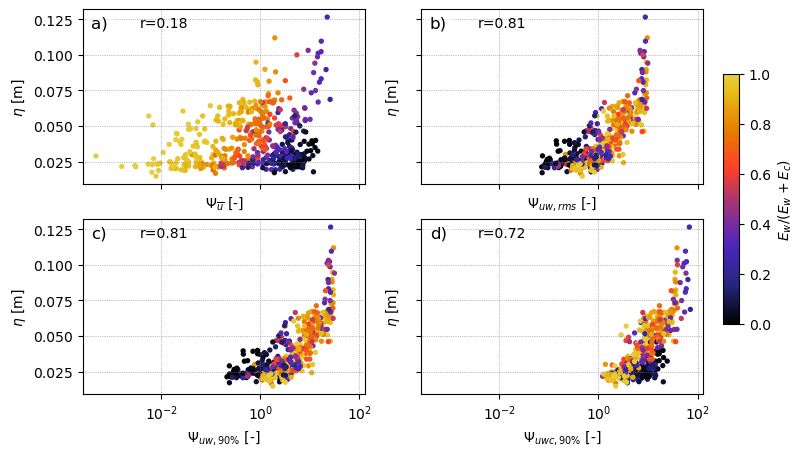

In [14]:
# focus on the ripple height as function of mobility number only
from scipy import stats 

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('CMRmap')
new_cmap = truncate_colormap(cmap, 0, 0.8)

# ripple cutof
aa=2e-2
bb=1.2
# aa=2.4e-2
# bb=1.5
# aa=1.8e-2
# bb=1.8
# dsi = ds[['uorb','umean', 'psi_umean', 'psi_uorb', 'psi_uwc',  'psi_uorbmax', 'labda','eta']].where(ds.labda<=(aa+bb*d0))
dsi = ds.sel(t=np.setdiff1d(ds.t.values, relict_times))
# dsi = ds.sel(t=relict_times)
# dsi = ds

fig, ax = plt.subplots(2, 2, figsize=[8, 5], sharex=True, sharey=True)
kwargs = {'vmin':0, 'vmax':1, 'cmap':new_cmap,'s':8}
a = dsi.psi_umean.values
b = dsi.eta.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
ax[0, 0].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **kwargs)
ax[0, 0].set_xlabel(r'$\Psi_{\overline{u}}$ [-]')
ax[0, 0].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[0, 0].transAxes)
# ax[0, 0].text(-0.1, 0.5, '$\eta$ [m]', transform = ax[0, 0].transAxes, rotation=90, ha='center', va='center')
ax[0, 0].set_ylabel('$\eta$ [m]')

a = dsi.psi_uorb.values 
b = dsi.eta.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
ax[0, 1].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **kwargs)
ax[0, 1].set_xlabel(r'$\Psi_{uw,rms}$ [-]')
ax[0, 1].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[0, 1].transAxes)
ax[0, 1].text(-0.1, 0.5, '$\eta$ [m]', transform = ax[0, 1].transAxes, rotation=90, ha='center', va='center')

a = dsi.psi_uorbmax.values 
b = dsi.eta.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
ax[1, 0].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **kwargs)
ax[1, 0].set_xlabel(r'$\Psi_{uw,90\%}$ [-]')
ax[1, 0].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[1, 0].transAxes)
# ax[1, 0].text(-0.1, 0.5, '$\eta$ [m]', transform = ax[1, 0].transAxes, rotation=90, ha='center', va='center')
ax[1, 0].set_ylabel('$\eta$ [m]')

a = dsi.psi_uwc.values
b = dsi.eta.values
dat = np.vstack([a,b]).T
dat = dat[~np.isnan(dat).any(axis=-1)]
r = stats.spearmanr(dat[:, 0], dat[:, 1])
im=ax[1, 1].scatter(a, b, c=dsi.uorb**2/(dsi.umean**2+dsi.uorb**2), **kwargs)
ax[1, 1].set_xlabel(r'$\Psi_{uwc,90\%}$ [-]')
ax[1, 1].text(0.2, 0.9, 'r={:.2f}'.format(r.correlation), transform = ax[1, 1].transAxes)
ax[1, 1].text(-0.1, 0.5, '$\eta$ [m]', transform = ax[1, 1].transAxes, rotation=90, ha='center', va='center')


# fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.25, 0.02, 0.5])
plt.colorbar(im, label='$E_w$/($E_w+E_c$)', cax=cbar_ax)

for axi in ax.reshape(-1):
    axi.set_xscale('log')
    # axi.set_yscale('log')
    # axi.set_ylim([1e-2, 1.5e-1])
    axi.grid(linestyle=':', linewidth=0.5, color='grey')

# fig.tight_layout()
import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)', 'c)', 'd)'], ax.reshape(-1)):
    t = axi.text(0.0, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

plt.savefig(os.path.join(plotFilePath, 'mobilitynumber_skill_orbital.png'), dpi=200, bbox_inches='tight')

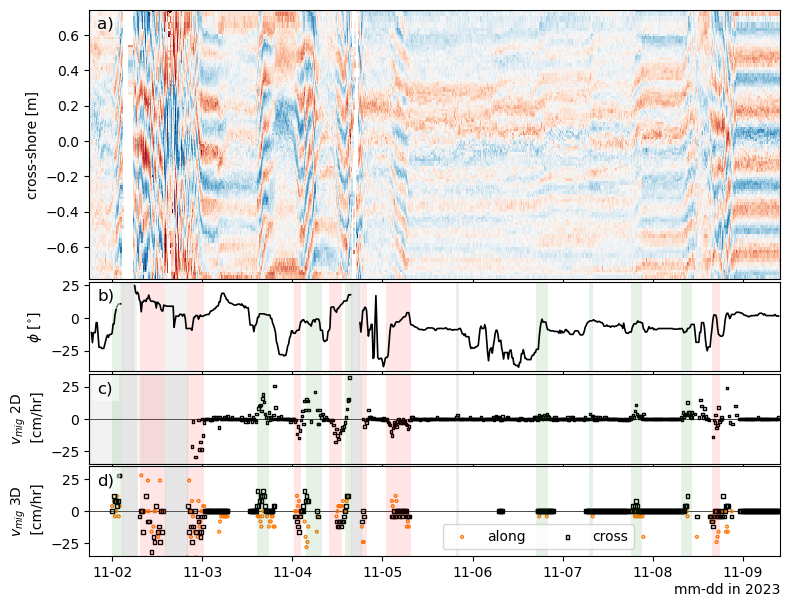

In [15]:
# version with the cross-shore transect timestack included
dscros = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\processed\migration_cross.nc')

fig, ax = plt.subplots(4, 1, figsize=[8, 6], sharex=True, height_ratios= [3,1,1, 1])

Y,X =np.meshgrid(-dscros['x'], dscros['time'])
im=ax[0].pcolor(X, Y, dscros['zb1'].values, vmin=-0.05, vmax=0.05, cmap='RdBu')
ax[0].set_ylabel('cross-shore [m]')
# plt.colorbar(im)

ax[1].plot(ds.t, ds.phi.rolling(t=1).mean(), color='k', linewidth=1.2)
ax[1].set_ylabel('$\phi$ [$^{\circ}$]')

ax[2].scatter(mig1d['time'], mig1d['vmig_cross'].where(mig1d.p>0.5), marker='s', s=3, color='None', edgecolor='k', label='cross')
ax[2].set_ylabel('$v_{mig}$ 2D\n [cm/hr]')
ax[2].set_ylim([-35, 35])
ax[2].axhline(0, color='k', linewidth=0.5, zorder=-2)

# ax[3].scatter(mig['time'], mig['vmig_along'].where(np.minimum(mig.percvalid1, mig.percvalid2)>0.5).where(mig.p>0.5), marker='o', s=4, color='None', edgecolor='C1', label='along')
# ax[3].scatter(mig['time'], mig['vmig_cross'].where(np.minimum(mig.percvalid1, mig.percvalid2)>0.5).where(mig.p>0.5), marker='s', s=7, color='None', edgecolor='k', label='cross')
ax[3].scatter(ds['t'], ds['vmig_along'].where(~np.isnan(ds.labda3d)), marker='o', s=4, color='None', edgecolor='C1', label='along')
ax[3].scatter(ds['t'], ds['vmig_cross'].where(~np.isnan(ds.labda3d)), marker='s', s=7, color='None', edgecolor='k', label='cross')

ax[3].axhline(0, color='k', linewidth=0.5, zorder=-2)
ax[3].set_ylim([-35, 35])
ax[3].set_ylabel('$v_{mig}$ 3D\n [cm/hr]')
ax[3].legend(ncol=2, loc='best', bbox_to_anchor=(0.4, 0., 0.5, 0.5))
ax[3].xaxis.set_major_formatter(DateFormatter('%m-%d'))

alpha=0.1
for axi in ax[1:2]:
    axi.axvspan(pd.to_datetime('20231102 02:30'), pd.to_datetime('20231102 05:30'), alpha=alpha, color='grey') # missing data
    axi.axvspan(pd.to_datetime('20231104 15:30'), pd.to_datetime('20231104 17:45'), alpha=alpha, color='grey') # missing data

for axi in ax[2:3]:
    axi.axvspan(pd.to_datetime('20231101 18:0'), pd.to_datetime('20231102 20:00'), alpha=alpha, color='grey') # missing data
    axi.axvspan(pd.to_datetime('20231104 15:30'), pd.to_datetime('20231104 18:15'), alpha=alpha, color='grey') # missing data

for axi in ax[3:4]:
    axi.axvspan(pd.to_datetime('20231102 02:30'), pd.to_datetime('20231102 06:30'), alpha=alpha, color='grey') # missing data
    axi.axvspan(pd.to_datetime('20231102 14:00'), pd.to_datetime('20231102 20:00'), alpha=alpha, color='grey') # missing data
    axi.axvspan(pd.to_datetime('20231104 15:30'), pd.to_datetime('20231104 18:15'), alpha=alpha, color='grey') # missing data

plot_migrating_moments(ax[1:4], alpha=alpha)
fig.tight_layout()
fig.subplots_adjust(hspace=0.02)

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)', 'c)', 'd)'], ax):
    t = axi.text(0.0, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

ax[-1].text(1, -0.3, 'mm-dd in 2023',transform = ax[-1].transAxes, ha='right', va='top')

plt.savefig(os.path.join(plotFilePath, 'cross-shoremigration_axvspan.png'), dpi=200, bbox_inches='tight')

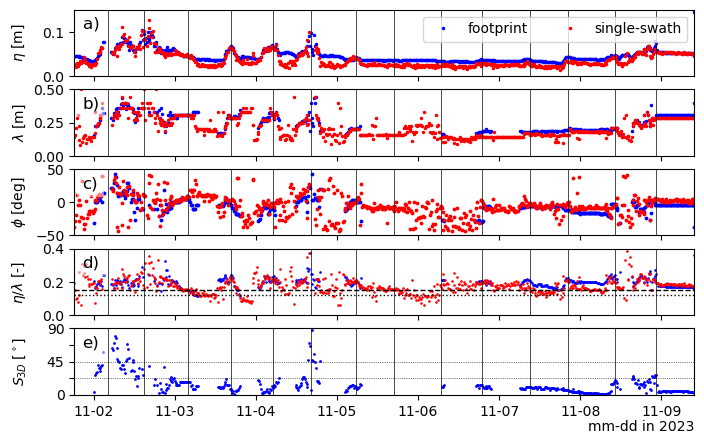

In [16]:
# only on those moments that p is sufficiently high
fig, ax = plt.subplots(5,1, sharex=True, figsize=[8, 5])

ax[0].plot(rib2d['time'], rib2d['eta'], marker='.', linestyle='None', color='blue', ms=3)
ax[0].plot(rib1d['time'], rib1d['etamin'], marker='.', linestyle='None', color='red', ms=3)

ax[1].plot(rib2d['time'], rib2d['labda'], marker='.', linestyle='None', color='blue', ms=3)
ax[1].plot(rib1d['time'], rib1d['labdamin'], marker='.', linestyle='None', color='red', ms=3)
ax[1].set_ylim([0, 0.5])

ax[2].scatter(rib2d['time'], rib2d['phi'], color='blue', s=3)
# ax[2].fill_between(rib2d['time'], np.maximum(rib2d['phi'], rib2d['phi_mean']*180/np.pi-90), np.minimum(rib2d['phi'], rib2d['phi_mean']*180/np.pi-90), color='grey',alpha=0.5)
ax[2].scatter(rib1d['time'], rib1d['phi'], color='red', s=3)
# ax[2].plot(ripple_dir.time, ripple_dir, color='k', linewidth=1, linestyle='None', marker='.', markersize=1)
ax[2].set_ylabel(r'$\phi$ [deg]')
ax[2].set_ylim([-50, 50])

ax[3].scatter(rib2d['time'], rib2d['eta']/rib2d['labda'], marker='.', linestyle='None', color='blue', s=3)
ax[3].scatter(rib1d['time'], rib1d['etamin']/rib1d['labdamin'], marker='.', linestyle='None', color='red', s=3)
ax[3].set_ylabel(r'$\eta/\lambda$ [-]')
ax[3].axhline(0.12, color='k', linestyle=':', linewidth=1)
ax[3].axhline(0.15, color='k', linestyle='--', linewidth=1)
ax[3].set_ylim([0, 0.4])
# ax[3].plot(mig['time'], mig['vmig_cross'].where(mig.p>0.8), marker='.', linestyle='None', color='blue', ms=3)
# ax[3].plot(mig1d['time'], mig1d['vmig_cross'].where(mig1d.p>0.8), marker='.', linestyle='None', color='red', ms=3)
# # ax[3].plot(mig1d['time'], (np.cos(mig1d.phi/180*np.pi)*mig1d.dmig).where(mig1d.p>0.8), marker='.', linestyle='None', color='red', ms=3)
# ax[4].plot(mig['time'], mig['vmig_along'].where(mig.p>0.8), marker='.', linestyle='None', color='blue', ms=3)
# ax[5].plot(mig['time'], mig['p'], marker='.', linestyle='None', color='blue', ms=3)
# ax[5].plot(mig1d['time'], mig1d['p'], marker='.', linestyle='None', color='red', ms=3)
# ax[3].set_ylabel('$v_{cross}$\n [cm/hr]')
# ax[3].axhline(0, color='k', linewidth=1, zorder=-4)
# ax[4].axhline(0, color='k', linewidth=1, zorder=-4)
# ax[4].set_ylabel('$v_{along}$\n [cm/hr]')
# ax[5].set_ylabel('p [-]')
ax[4].plot(rib2d.time, rib2d.spreading, marker='.', linestyle='None', color='blue', ms=2)
ax[4].set_ylabel('$S_{3D}$ [$^\circ$]')
ax[4].set_ylim([0, 90])
ax[4].set_yticks([0, 22.5, 45, 67.7, 90])
ax[4].set_yticklabels(['0','', '45', '', '90'])
ax[4].axhline(45, linewidth=0.5, color='k', linestyle=':')
ax[4].axhline(22.5, linewidth=0.5, color='k', linestyle=':')
ax[0].legend(['footprint', 'single-swath'], ncols=2, loc='best')
ax[0].set_ylabel('$\eta$ [m]')
ax[0].set_ylim([0, 0.15])
ax[1].set_ylabel('$\lambda$ [m]')

# plot_migrating_moments(ax)
ax[-1].set_xlim([mig.time.min(), mig.time.max()])
ax[-1].xaxis.set_major_formatter(DateFormatter('%m-%d'))

fig.align_ylabels()
from scipy import signal
ii = signal.find_peaks(-ds.d, distance=pd.to_timedelta('5H')/(ds.t[1]-ds.t[0]))[0]
for axi in ax:
    for i in ii:
        ti = ds.t.isel(t=i).values
        d = ds.d.isel(t=i).values
        if (d<1.45):
            axi.axvline(ti, color='k', linewidth=0.5)

ax[-1].text(1, -0.38, 'mm-dd in 2023',transform = ax[-1].transAxes, ha='right', va='top')

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)', 'c)', 'd)', 'e)'], ax):
    t = axi.text(0.0, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

plt.savefig(os.path.join(plotFilePath, '1D_2D_stats.png'), dpi=200, bbox_inches='tight')

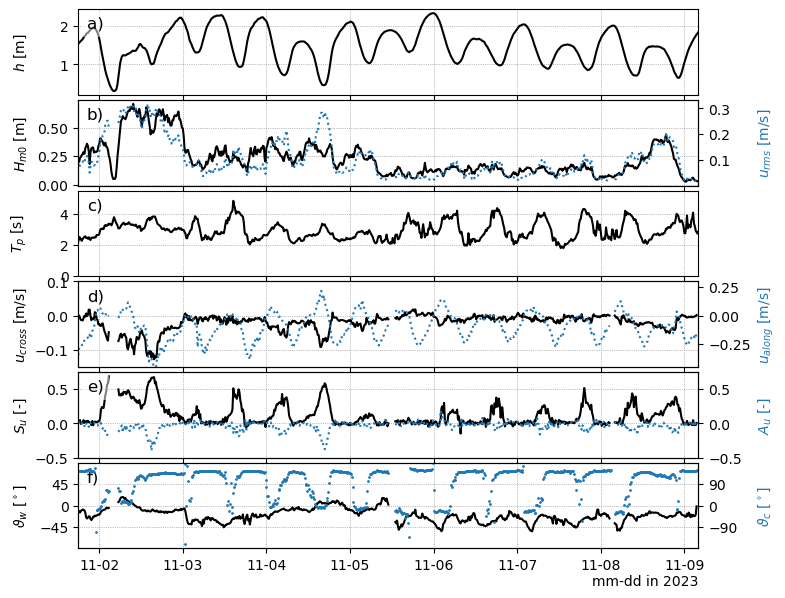

In [17]:
# en nog een manier van plotten
vec = ds

fig, ax = plt.subplots(6, 1, figsize=[8, 7], sharex=True)

ax[0].plot(vec.t, (vec.zs-vec.zb), label='obs', color='k')
ax[0].set_ylabel('$h$ [m]')

(vec.Hm0).plot(label='obs', color='k', linestyle='-', ax=ax[1])
tax = ax[1].twinx()

ax[1].set_ylabel('$H_{m0}$ [m]')
vec.u_ssm.plot(label='obs', color='C0', linestyle=':', ax=tax)
tax.set_title('')
tax.set_ylabel('$u_{rms}$ [m/s]', color='C0')

vec.Tmm10.plot(label='obs', linestyle='-', color='k', ax=ax[2])
ax[2].set_ylabel('$T_{m-1,0}$ [s]', color='k')
ax[2].set_ylabel('$T_p$ [s]')
ax[2].set_ylim([0, 5.5])
ax[2].set_yticks([0, 2, 4])

tax3 = ax[3].twinx()
(vec.ucm).plot(label='across', color='k', ax=ax[3])
(vec.ulm).plot(label='along', color='C0', linestyle=':', ax=tax3)
ax[3].set_ylabel('$u_{cross}$ [m/s]', color='k')
tax3.set_ylabel('$u_{along}$ [m/s]', color='C0')
tax3.set_title('')
ax[3].set_ylim([-0.15, 0.10])
tax3.set_ylim([-0.45, 0.3])

vec.nSk.plot(label='$S_u$', color='k', ax=ax[4])
tax4 = ax[4].twinx()
vec.nAs.plot(label='$A_u$', color='C0', linestyle=':', ax=tax4)
ax[4].set_ylabel('$S_u$ [-]', color='k')
tax4.set_ylabel('$A_u$ [-]', color='C0')
ax[4].set_ylim([-0.5, 0.75])
tax4.set_ylim([-0.5, 0.75])
tax4.set_title('')

# ax[5].plot(ds.t, ds.phi-10, color='C0', marker='.', linestyle='None', ms=2)
ax[5].plot(vec.t,((vec.puvdir)%360-122), label='obs', color='k')
tax5 = ax[5].twinx()
thetc = np.arctan2(vec.ulm, vec.ucm)*180/np.pi-123
thetc = np.where(thetc<180, thetc, thetc-360)
thetc = np.where(thetc>-180, thetc, thetc+360)
tax5.plot(vec.t, thetc, color='C0', ms=2, marker='.', linestyle='None')
ax[5].set_ylabel(r'$\vartheta_w$ [$^\circ$]', color='k')
tax5.set_ylabel(r'$\vartheta_c$ [$^\circ$]', color='C0')
tax5.set_title('')
ax[5].set_ylim([-90, 90])
tax5.set_ylim([-180, 180])
tax5.set_yticks([-90, 0, 90])
ax[5].set_yticks([-45, 0, 45])

# time instants we have bathymetric data
tv1 = pd.to_datetime('20231101 17:00')
tv2 = pd.to_datetime('20231103 16:00')
tv3 = pd.to_datetime('20231108 09:00')

# plot_migrating_moments(ax)

for axi in ax[:-1]:
    axi.set_xlabel('')

ax[1].set_xlim(vec.t.min(), pd.to_datetime('20231109 04:00'))
fig.align_ylabels()
ax[-1].xaxis.set_major_formatter(DateFormatter('%m-%d'))
for axin in ax:
    axin.set_title('')
    axin.grid(linestyle=':', color='grey', linewidth=0.5)
fig.subplots_adjust(hspace=0.06)

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)','c)', 'd)','e)', 'f)'], ax):
    t = axi.text(0.0, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

ax[-1].text(1, -0.3, 'mm-dd in 2023',transform = ax[-1].transAxes, ha='right', va='top')

plt.savefig(os.path.join(plotFilePath, 'ts_hydro.png'), dpi=200, bbox_inches='tight')



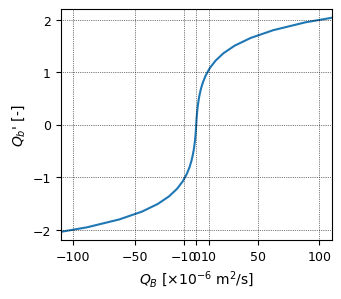

In [18]:
x0 = np.logspace(-5, 2.4,50)
x = np.concatenate([-np.flipud(x0), x0])
fig, ax = plt.subplots(figsize=[3.5, 3])
plt.plot(x, np.sign(x)*np.log10(np.abs(x)+1))
plt.axvline(-100, linewidth=0.5, color='k', linestyle=':')
plt.axvline(-50, linewidth=0.5, color='k', linestyle=':')
plt.axvline(-10, linewidth=0.5, color='k', linestyle=':')
plt.axvline(0, linewidth=0.5, color='k', linestyle=':')
plt.axvline(10, linewidth=0.5, color='k', linestyle=':')
plt.axvline(50, linewidth=0.5, color='k', linestyle=':')
plt.axvline(100, linewidth=0.5, color='k', linestyle=':')
plt.axhline(2, linewidth=0.5, color='k', linestyle=':')
plt.axhline(1, linewidth=0.5, color='k', linestyle=':')
plt.axhline(0, linewidth=0.5, color='k', linestyle=':')
plt.axhline(-1, linewidth=0.5, color='k', linestyle=':')
plt.axhline(-2, linewidth=0.5, color='k', linestyle=':')
plt.xticks([-100, -50, -10, 0, 10, 50, 100], fontsize=9)
plt.yticks([-2, -1, 0, 1, 2], fontsize=9)
plt.xlabel(r'$Q_B$ [$\times 10^{-6}$ m$^2$/s]')
plt.ylabel('$Q_b$\' [-]')
plt.axis([-110, 110, -2.2, 2.2])
plt.savefig(os.path.join(plotFilePath, 'logmod_transform.png'), dpi=200, bbox_inches='tight')


In [19]:
# give some values to put into the text
qb2d = ds['vmig_cross']/3600/100*ds['eta']*0.5*(1-0.3)
qmin = qb2d[qb2d>0].max()
qmax= qb2d[qb2d<0].min()
print('from 2d analysis: qmin={:.1e} m2/s and qmax = {:.1e} m2/s'.format(qmin, qmax))

qb1d = mig1d.vmig_cross.rename({'time':'t'}).interp_like(ds.t)/3600/100*ds['eta']*0.5*(1-0.3)
qmin = qb1d[qb1d>0].max()
qmax= qb1d[qb1d<0].min()
print('from 1d analysis: qmin={:.1e} m2/s and qmax = {:.1e} m2/s'.format(qmin, qmax))
print('from 1d analysis in logtransform: qmin={:.2f} and qmax = {:.2f}'.format(np.sign(1e6*qmin)*np.log(np.abs(1e6*qmin)+1), np.sign(1e6*qmax)*np.log(np.abs(1e6*qmax)+1)))

print('\n Were going to remove some outliers: \n')
ii = np.sign(1e6*qb1d)*np.log(np.abs(1e6*qb1d)+1)
qd1 = np.where(ii<2, np.where(ii>-2,qb1d, np.nan), np.nan)
ii = np.sign(1e6*qb2d)*np.log(np.abs(1e6*qb2d)+1)
qd2 = np.where(ii<2, np.where(ii>-2,qb2d, np.nan), np.nan)

qd = np.where(~np.isnan(qd1), qd1, qd2)
# qd = np.where(np.isnan(qb2d), np.nan, qd)

qmin = qd1[qd1>0].max()
qmax= qd1[qd1<0].min()
print('from 1d analysis: qmin={:.1e} m2/s and qmax = {:.1e} m2/s'.format(qmin, qmax))
print('from 1d analysis in logtransform with bounds: qmin={:.2f} and qmax = {:.2f}'.format(np.sign(1e6*qmin)*np.log(np.abs(1e6*qmin)+1), np.sign(1e6*qmax)*np.log(np.abs(1e6*qmax)+1)))

qmin = qd[qd>0].max()
qmax= qd[qd<0].min()
print('from comb analysis: qmin={:.1e} m2/s and qmax = {:.1e} m2/s'.format(qmin, qmax))
print('from comb analysis in logtransform with bounds: qmin={:.2f} and qmax = {:.2f}'.format(np.sign(1e6*qmin)*np.log(np.abs(1e6*qmin)+1), np.sign(1e6*qmax)*np.log(np.abs(1e6*qmax)+1)))

ds['Tcross'] = ('t', np.sign(1e6*qd)*np.log(np.abs(1e6*qd)+1))
ds['Tcross_dimensional'] = ('t', qd)
# ds['vmig_cross_comb'] = qd1

from 2d analysis: qmin=1.6e-06 m2/s and qmax = -2.7e-06 m2/s
from 1d analysis: qmin=9.1e-06 m2/s and qmax = -1.2e-05 m2/s
from 1d analysis in logtransform: qmin=2.31 and qmax = -2.56

 Were going to remove some outliers: 

from 1d analysis: qmin=6.2e-06 m2/s and qmax = -5.8e-06 m2/s
from 1d analysis in logtransform with bounds: qmin=1.98 and qmax = -1.92
from comb analysis: qmin=6.2e-06 m2/s and qmax = -5.8e-06 m2/s
from comb analysis in logtransform with bounds: qmin=1.98 and qmax = -1.92


In [20]:
# scale velocity to 2 cm above the bed
z=0.02
ds['ucm_nb'] = uz(ds['ucm'], z, d50=d50)
ds['ucm_nb2'] = uz(ds['ucm'], z, Tmm10=ds.Tmm10.values, u_orb=np.sqrt(2)*ds.ud_ssm.values, d50=d50)
ds['uc_nb2'] = ds['uc']-ds['ucm']+ds['ucm_nb2']

ds['ulm_nb'] = uz(ds['ulm'], z, d50=d50)
ds['ulm_nb2'] = uz(ds['ulm'], z, Tmm10=ds.Tmm10.values, u_orb=np.sqrt(2)*ds.ud_ssm.values, d50=d50)
ds['ul_nb2'] = ds['ul']-ds['ulm']+ds['ulm_nb2']

In [25]:
g=9.8
rho_s=2650
rho_w=1025
nu=1e-6
d50 = 630e-6

theta_crit = critical_shields(d50, delta=(rho_s-rho_w)/rho_w, nu=nu, g=g, method='soulsby_whitehouse97')


# total velocity
theta_prime_c = shields_parameter_ribberink98(ds, d50, g=g, rho_s=rho_s, rho_w=rho_w, option=7)
theta_prime_l = shields_parameter_ribberink98(ds, d50, g=g, rho_s=rho_s, rho_w=rho_w, option=7+1)
theta_prime_mag = np.sqrt(theta_prime_c**2+theta_prime_l**2)
theta_eff = theta_prime_mag -theta_crit
percexceed0 = (theta_eff>0).sum(dim='N')/len(ds.N)*100
q0 = 1e6*bedload_ribberink98(ds, d50=d50, option=7)
qp0= np.sign(q0)*np.log(np.abs(q0)+1)

#total velocity near bed
theta_prime_c = shields_parameter_ribberink98(ds.drop_vars(['uc', 'ul']).rename({'uc_nb2':'uc', 'ul_nb2':'ul'}), d50, g=g, rho_s=rho_s, rho_w=rho_w, option=7)
theta_prime_l = shields_parameter_ribberink98(ds.drop_vars(['uc', 'ul']).rename({'uc_nb2':'uc', 'ul_nb2':'ul'}), d50, g=g, rho_s=rho_s, rho_w=rho_w, option=7+1)
theta_prime_mag = np.sqrt(theta_prime_c**2+theta_prime_l**2)
theta_eff = theta_prime_mag -theta_crit
percexceed1 = (theta_eff>0).sum(dim='N')/len(ds.N)*100
q1 = 1e6*bedload_ribberink98(ds.drop_vars(['uc', 'ul']).rename({'uc_nb2':'uc', 'ul_nb2':'ul'}), d50=d50, option=7)
qp1= np.sign(q1)*np.log(np.abs(q1)+1)

# u-u_mean
theta_prime_c = shields_parameter_ribberink98(ds.drop_vars(['uc', 'ul']).rename({'uc_nb2':'uc', 'ul_nb2':'ul'}), d50, g=g, rho_s=rho_s, rho_w=rho_w, option=41)
theta_prime_l = shields_parameter_ribberink98(ds.drop_vars(['uc', 'ul']).rename({'uc_nb2':'uc', 'ul_nb2':'ul'}), d50, g=g, rho_s=rho_s, rho_w=rho_w, option=41+1)
theta_prime_mag = np.sqrt(theta_prime_c**2+theta_prime_l**2)
theta_eff = theta_prime_mag -theta_crit
percexceed2 = (theta_eff>0).sum(dim='N')/len(ds.N)*100
q2 = 1e6*bedload_ribberink98(ds, d50=d50, option=35)
qp2 = np.sign(q2)*np.log(np.abs(q2)+1)

# sea swell only
theta_prime_c = shields_parameter_ribberink98(ds.drop_vars(['uc', 'ul']).rename({'uc_nb2':'uc', 'ul_nb2':'ul'}), d50, g=g, rho_s=rho_s, rho_w=rho_w, option=45)
theta_prime_l = shields_parameter_ribberink98(ds.drop_vars(['uc', 'ul']).rename({'uc_nb2':'uc', 'ul_nb2':'ul'}), d50, g=g, rho_s=rho_s, rho_w=rho_w, option=45+1)
theta_prime_mag = np.sqrt(theta_prime_c**2+theta_prime_l**2)
theta_eff = theta_prime_mag -theta_crit
percexceed3 = (theta_eff>0).sum(dim='N')/len(ds.N)*100
q3 = 1e6*bedload_ribberink98(ds, d50=d50, option=29)
qp3 = np.sign(q3)*np.log(np.abs(q3)+1)


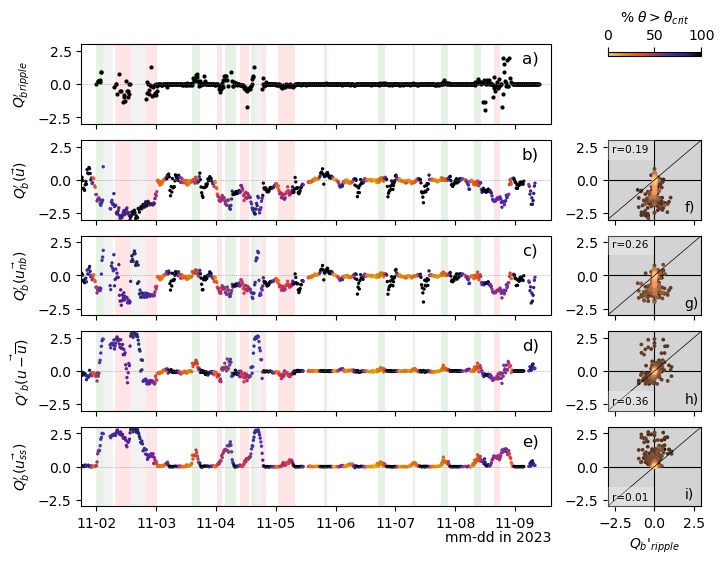

In [ ]:
# combined observed ripple pattern, and consistent yscales
def my_density_scatter(q, qs, ax, loc='bottom'):
    ax.plot([-3, 3], [-3, 3], linewidth=0.5, color='k')

    innan = ~np.logical_or(np.isnan(q), np.isnan(qs))
    q = q[innan]
    qs = qs[innan]
    px = np.sign(qs)*np.log(np.abs(qs)+1)
    py = np.sign(q)*np.log(np.abs(q)+1)
    ran0 = [np.min([np.min(px), np.min(py)]), np.max([np.max(px), np.max(py)])]
    ran = [ran0, ran0]
    # ran = [[-2, 2], [-2, 2]]
    density_scatter(px, py, ax=ax, range=ran, bins=40, **{'cmap':'copper', 's':3})
    if loc=='bottom':
        t = ax.text(0.05, 0.05, 'r={:.2f}'.format(spearman_stats(q, qs).correlation), transform=ax.transAxes, ha='left', va='bottom', fontsize=7.5)
        t.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='None'))
    else:
        t = ax.text(0.05, 0.95, 'r={:.2f}'.format(spearman_stats(q, qs).correlation), transform=ax.transAxes, ha='left', va='top', fontsize=7.5)   
        t.set_bbox(dict(facecolor='white', alpha=0.3, edgecolor='None'))     
    
    return

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('CMRmap_r')
new_cmap = truncate_colormap(cmap, 0.2, 1.0)

fig, ax = plt.subplots(5, 2, figsize=[8,6], gridspec_kw={"width_ratios":[5, 1]})

# observed
ax[0, 0].plot(ds.t, ds.Tcross, c='k', marker='o', ms=2, linestyle='None', label='$ripples$')
ax[0, 0].set_ylabel('$Q_b\'_{ripple}$')

# total signal
im = ax[1, 0].scatter(ds.t, qp0, c=percexceed0, cmap=new_cmap, vmin=0, vmax=100, s=2)
plt.colorbar(im, label=r'% $\theta>\theta_{crit}$', ax=ax[0, 1], orientation='horizontal', location='top')
my_density_scatter(q0, ds.Tcross.values, ax[1, 1], loc='top')
ax[1, 0].set_ylabel('$Q_b\' (\\vec{u})$')

# meanflow to nearbed
ax[2, 0].scatter(ds.t, qp1, c=percexceed1, cmap=new_cmap, vmin=0, vmax=100, s=2)
my_density_scatter(q1, ds.Tcross.values, ax[2, 1], loc='top')
ax[2, 0].set_ylabel('$Q_b\' (\\vec{u_{nb}})$')

# ig + seaswell
ax[3, 0].scatter(ds.t, qp2, c=percexceed2, cmap=new_cmap, vmin=0, vmax=100, s=2)
my_density_scatter(q2, ds.Tcross.values, ax[3, 1])
ax[3, 0].set_ylabel('$Q\'_b (\\vec{u-\overline{u}})$')

# seaswell only
ax[4, 0].scatter(ds.t, qp3, c=percexceed3, cmap=new_cmap, vmin=0, vmax=100, s=2)
my_density_scatter(q3, ds.Tcross.values, ax[4, 1])
ax[4, 0].set_ylabel('$Q_b\' (\\vec{u_{ss}})$')

ax[0, 1].axis('off')

# plot_migrating_moments2(ax[:, 0])
plot_migrating_moments(ax[:, 0], alpha=0.1)
# formatting
for axi in ax[:, 0]:
    axi.set_xlim([ds.t.min(), ds.t.max()])
    axi.axhline(0, color='grey', linewidth=0.5, linestyle=':')
for axi in ax[:-1, 0]:
    axi.set_xticklabels([])
for axi in ax[1:-1, 1]:
    axi.set_xticklabels([]) 
for axi in ax[1:, 1]:
    axi.set_facecolor('lightgrey')
    axi.axhline(0, color='k', zorder=-2, linewidth=0.8)
    axi.axvline(0, color='k', zorder=-2, linewidth=0.8)
    axi.set_xlim([-3, 3])
for axi in ax.reshape(-1):
    axi.set_ylim([-3, 3])

ax[-1, 0].xaxis.set_major_formatter(DateFormatter('%m-%d'))
ax[-1, 1].set_xlabel('$Q_b$\'$_{ripple}$') 
ax[-1, 0].text(1, -0.3, 'mm-dd in 2023',transform = ax[-1, 0].transAxes, ha='right', va='top')

fig.align_ylabels()

# numbering of subpanels
trans = mtransforms.ScaledTranslation(6 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)','c)', 'd)','e)'], ax[:,0]):
    t = axi.text(0.92, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))
for label, axi in zip(['f)', 'g)','h)', 'i)'], ax[1:,1]):
    t = axi.text(0.73, 0.33, label, transform=axi.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    t.set_bbox(dict(facecolor='None', alpha=0.5, edgecolor='None'))

plt.savefig(os.path.join(plotFilePath, 'bed_load_transport_qbdash_d50_' + '{:.0f}'.format(1e6*d50) + 'percexceed_axvspan.png'), dpi=200, bbox_inches='tight')


In [27]:
# maximum transport solely by IG waves
q = 1e6*bedload_ribberink98(ds, d50=500e-6, option=31)
qp = np.sign(q)*np.log(np.abs(q)+1)
print('infragravity variance only: max(q)={:.2f}e-6 m2/s, Q_b\'={:.2f}'.format(np.max(np.abs(q)), np.max(np.abs(qp))))

infragravity variance only: max(q)=0.21e-6 m2/s, Q_b'=0.19


Text(0.5, 1.0, 'reconstruct needed velocity')

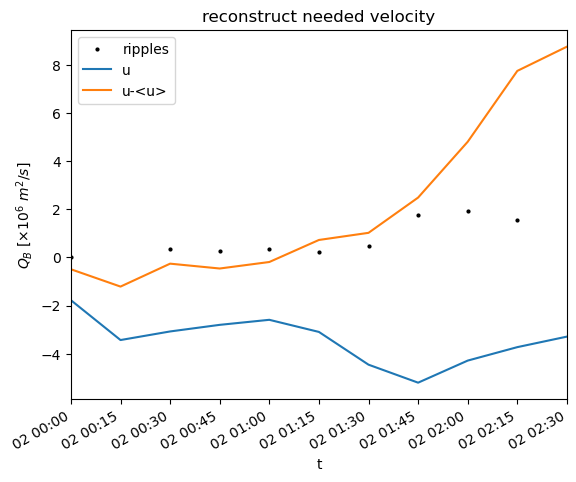

In [28]:
dsi = ds.sel(t=slice('20231102 00:00', '20231102 02:30'))

mig['eta']=ds['eta'].rename({'t':'time'}).interp_like(mig.time)
qs = 1e6*mig['vmig_cross']/3600/100*mig['eta']*0.6*(1-0.3)
plt.plot(mig.time, qs, c='k', marker='o', ms=2, linestyle='None', label='$ripples$')

# with raw velocity signal
q = 1e6*bedload_ribberink98(dsi, d50=500e-6, option=7)
q.plot()

# reconstruct velocity
dsi['uc_re'] = ds['uc']-ds['uc'].mean(dim='N')
dsii = dsi.drop_vars(['uc']).rename({'uc_re':'uc'})
q = 1e6*bedload_ribberink98(dsii, d50=500e-6, option=7)
q.plot()
plt.ylabel(r'$Q_B$ [$\times 10^6 \ m^2/s$]')

plt.xlim([dsi.t.min(), dsi.t.max()])
plt.legend(['ripples', 'u', 'u-<u>'])
plt.title('reconstruct needed velocity')

In [29]:
# crude estimation of the volume change in the profile below the frame
0.5*4*0.15

0.3

In [30]:
# prepare cumulative transports
dt = (ds['t'][1]-ds['t'][0])/pd.to_timedelta('1s')
dss = ds[['Tcross', 'eta', 'ucm', 'ulm', 'uc', 'uc2', 'ul2', 'uc3', 'ul3', 'ul', 'Tmm10', 'ud_ssm', 'uc2_ss', 'ul2_ss', 'uc2_ig', 'ul2_ig']].sel(t=slice('20231103 16:00', '20231108 09:00')).dropna(dim='t')
dss2 = ds[['ucm', 'ulm', 'uc', 'uc2', 'ul2', 'uc3', 'ul3', 'ul', 'Tmm10', 'ud_ssm', 'uc2_ss', 'ul2_ss', 'uc2_ig', 'ul2_ig']].sel(t=slice('20231103 16:00', '20231108 09:00')).dropna(dim='t')

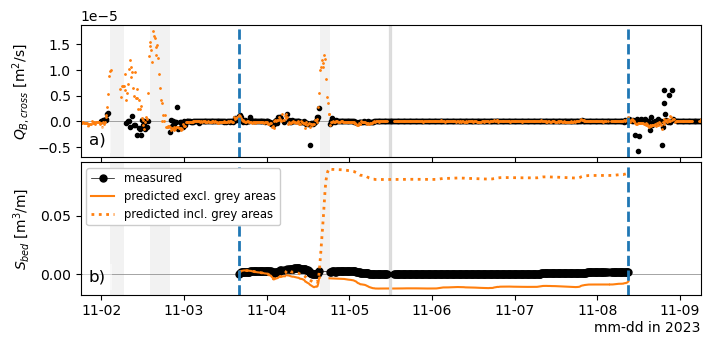

In [31]:
# plot dimensieloze transport en daaronder de dimensieloze shields parameter
fig, ax = plt.subplots(2, 1, figsize=[8, 3.5], sharex=True)

ax[0].plot(ds.t, ds.Tcross_dimensional, marker='.', color='k', linestyle='None')
ax[0].plot(ds.t, bedload_ribberink98(ds, d50=d50, option=39), linestyle='None', marker='.', ms=2, c='C1')
ax[0].set_ylabel('$Q_{B,cross}$ [m$^2$/s]')

ax[1].plot(dss.t, 1e-6*np.cumsum(dss.Tcross)*dt, marker='o', ms=5, linestyle='-', label='measured', color='k', markeredgecolor='k', linewidth=0.5)
ax[1].set_ylabel(r'$S_{bed}$ [m$^3$/m]')

varp = np.cumsum(bedload_ribberink98(dss, d50=d50, option=39)).resample(t='15T').nearest(tolerance='15T')
ax[1].plot(varp.t, dt*varp, label='predicted excl. grey areas', linestyle='-', c='C1')

ax[1].plot(dss2.t, np.cumsum(bedload_ribberink98(dss2, d50=d50, option=39))*dt, label='predicted incl. grey areas', linestyle=':', c='C1', linewidth=2)

fig.align_ylabels()
ax[1].set_xlim([ds.t.min(), pd.to_datetime('20231109 06:00')])

leg = ax[1].legend(loc='upper left', framealpha=1, fontsize=8.4)

for axi in ax:
    
    axi.axvspan(pd.to_datetime('20231102 02:30'), pd.to_datetime('20231102 06:30'), alpha=alpha, ec=None, fc='grey') # missing data
    axi.axvspan(pd.to_datetime('20231102 14:00'), pd.to_datetime('20231102 20:00'), alpha=alpha, ec=None, fc='grey') # missing data
    axi.axvspan(pd.to_datetime('20231104 15:30'), pd.to_datetime('20231104 18:30'), alpha=alpha, ec=None, fc='grey') # missing data
    axi.axvspan(pd.to_datetime('20231105 11:30'), pd.to_datetime('20231105 12:15'), alpha=0.2, color='grey') # missing data

    axi.axvline(pd.to_datetime('20231103 16:00'), linewidth=2, color='C0', linestyle='--')
    axi.axvline(pd.to_datetime('20231108 09:00'), linewidth=2, color='C0', linestyle='--')

    axi.axhline(0, color='grey', linewidth=0.5, zorder=-2)

fig.subplots_adjust(hspace=0.04)

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(6 / 72, 18 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)'], ax):
    t = axi.text(0.0, 0.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))

ax[0].set_yticks(1e-5*np.array([-0.5, 0, 0.5, 1, 1.5]))
ax[1].xaxis.set_major_formatter(DateFormatter('%m-%d'))
ax[-1].text(1, -0.2, 'mm-dd in 2023',transform = ax[-1].transAxes, ha='right', va='top')

plt.savefig(os.path.join(plotFilePath, 'Total_transport2.png'), dpi=200, bbox_inches='tight')